# Code to Make Centerline for Aortic Dissection Test
## March 9, 2025

In [37]:
import numpy as np
from pyevtk.hl import imageToVTK, polyLinesToVTK, linesToVTK
import h5py
from scipy.interpolate import splev, splprep
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

In [5]:
# import the data we care about
with h5py.File("/Users/bkhardy/Downloads/images/preFenv2.mat", "r") as f:
    spacex = np.asarray(f["spacex"]).T
    spacey = np.asarray(f["spacey"]).T
    spacez = np.asarray(f["spacez"]).T
    origin = np.asarray(f["Origin"]).flatten().tolist()
    
with h5py.File("/Users/bkhardy/Downloads/images/centerline1.mat", "r") as f:
    skeleton = np.asarray(f["skel"]).T
    new_mask = np.asarray(f["new_mask"]).T
    
spacing = [0.75, 0.75, 0.75]

In [24]:
# CODE FROM OTHER PROJECT
def create_distance_matrix(points: np.ndarray) -> np.ndarray:
    """Create a distance matrix between all points in 3D space.

    Args:
        points (np.ndarray): location of points in 3D space

    Returns:
        np.ndarray: L2 norm distance matrix between all points

    """
    return np.sqrt(((points[:, :, None] - points[:, :, None].T) ** 2).sum(axis=1))

def greedy_tsp(cost_matrix: np.ndarray, start_idx: int = 0) -> list:
    """Return the path with the lowest cost using a greedy algorithm.

    Function that takes inspiration from the classic traveling salesman problem, but implemented
    with an extremely greedy method. An exact solution is far from guaranteed; the outcome is heavily
    dependent on the starting index. Essentially, each step in the path is determined by finding
    whichever adjacent point is the closest.

    Args:
        cost_matrix (np.ndarray): 2D array/matrix that stores the cost (generally some measure of distance)
        of moving from one point to another.
        start_idx (int, optional): Index of the point to start with. Defaults to 0.

    Returns:
        list: Returns the path with the lowest cost.

    """
    path = []
    path.append(start_idx)
    num_points = cost_matrix.shape[0]

    for i in range(num_points):
        cost_matrix[i, i] = np.nan

    valid_idx = set(np.arange(num_points))
    valid_idx.remove(start_idx)
    cost_matrix[:, start_idx] = np.nan

    position = start_idx
    while valid_idx:
        step = np.nanargmin(cost_matrix[position, :])
        path.append(step)
        valid_idx.remove(step)
        cost_matrix[:, step] = np.nan
        position = step

    return path


def smooth_skeletonize(skel: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Convert a binary segmentation to an array of smoothed skeleton points.

    Args:
        segmentation (np.ndarray): 3D binary segmentation array

    Returns:
        tuple: _description_

    """
    # NOTE: removed the skeleton generation since python can't remove small branches like matlab can?
    #skel = skeletonize(segmentation.astype(np.uint8))  # downcast to save time
    points = np.array(np.nonzero(skel)).T

    distance_matrix = create_distance_matrix(points)
    start = np.argmin(points[:, 2])
    best_path = greedy_tsp(distance_matrix, start)
    points = points[best_path]

    tck, u = splprep([points[:, 0], points[:, 1], points[:, 2]])
    new_points = splev(u, tck)
    first_deriv = splev(u, tck, der=1)

    return skel, points, np.asarray(new_points).T, np.asarray(first_deriv).T

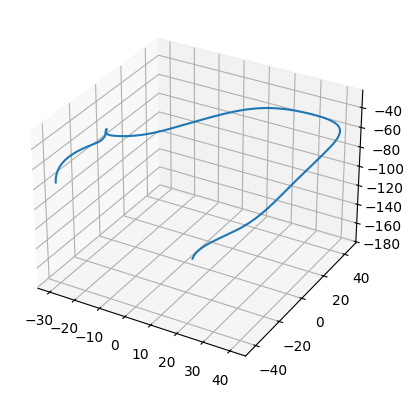

In [50]:
_, _, new_skeleton, derivatives = smooth_skeletonize(skeleton)
new_skeleton = new_skeleton * np.array(spacing) + np.array(origin) # convert to world coordinates -- hopefully this is enough lol
ax = plt.figure().add_subplot(projection='3d')
ax.plot(new_skeleton[:, 0], new_skeleton[:, 1], new_skeleton[:, 2])
plt.show()

In [51]:
#imageToVTK("preFenv2_241", origin=origin.tolist(), spacing=(0.75, 0.75, 0.75), cellData={"X": (spacex[:,:,:,1].copy(), spacey[:,:,:,1].copy(), spacez[:,:,:,1].copy())})
print([new_skeleton.shape[0]])
polyLinesToVTK("centerline1", new_skeleton[:, 0], new_skeleton[:, 1], new_skeleton[:, 2], np.array([new_skeleton.shape[0]]))

[338]


'/Users/bkhardy/Developer/GitHub/effective_stiffness/centerline1.vtu'

In [57]:
centerline2_idx = np.setdiff1d(np.arange(0, new_skeleton.shape[0]), np.arange(274, 290+1))
centerline2 = new_skeleton[centerline2_idx]
centerline2_normals = derivatives[centerline2_idx] / np.linalg.norm(derivatives[centerline2_idx], axis=1)[:, None]
setup_normals = (centerline2_normals[:,0].copy(), centerline2_normals[:,1].copy(), centerline2_normals[:,2].copy())
polyLinesToVTK("centerline2", centerline2[:, 0].copy(), centerline2[:, 1].copy(), centerline2[:, 2].copy(), np.array([centerline2.shape[0]]), pointData={"Normals": setup_normals})



'/Users/bkhardy/Developer/GitHub/effective_stiffness/centerline2.vtu'

In [ ]:
with h5py.File("centerline.h5", "w") as f:
    f.create_dataset("centerline_points", data=centerline2)
    f.create_dataset("centerline_normals", data=centerline2_normals)